1. Split frmer big function to singles

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io
import os


In [25]:
## Read all '.mat' data in one Subject
data_root = '/home/jinyanwei/Documents/JYW_COCHE/Project/MMBP/data/MMData'

'''Sub_combined_data_path = '/home/jinyanwei/Documents/JYW_COCHE/Project/MMBP/data/Sub_combined_data'
if not os.path.exists(Sub_combined_data_path):
    os.makedirs(Sub_combined_data_path)'''
    
## Dict Sub contains all subjects
Sub = {} 
Sub['sub_id'] = list(os.walk(data_root))[0][1] #len(Sub['sub_id']) = 15

def combine_all_subjects_row_data(i):
    Sub[f"{Sub['sub_id'][i]}"] = {}
    rest1_s = []
    CT_s = []
    recover_s = []
    rest2_s = []
    Sub[f"{Sub['sub_id'][i]}"]['seg'] = [n.split('.')[0] for n in list(os.walk(data_root))[i+1][2]]
    #print(Sub[f"{Sub['sub_id'][i]}"]['seg'])
    for s in Sub[f"{Sub['sub_id'][i]}"]['seg']:
        Sub[f"{Sub['sub_id'][i]}"][s] = scipy.io.loadmat(f"{data_root}/{Sub['sub_id'][i]}/{s}.mat")[s]
        for r in s.split('_'):
            if r in ['recover', 're', 'Recover']: #this seg is one of Recover
                recover_s.append(s)
            elif r in ['rest1']:
                rest1_s.append(s)
            elif r in ['CT', 'ct']:
                CT_s.append(s)
            elif r in ['rest2']:
                rest2_s.append(s)
            elif r in ['rest']:
                rest_index = s.split('_').index('rest')
                if s.split('_')[rest_index + 1] == '1':
                    rest1_s.append(s)
                else:
                    rest2_s.append(s)

    #print(rest1_s)
    ## Type 4 stage in one Subject
    Sub[f"{Sub['sub_id'][i]}"]['rest1'] = np.concatenate([Sub[f"{Sub['sub_id'][i]}"][si] for si in rest1_s], axis=1)
    r1code = np.full((1, Sub[f"{Sub['sub_id'][i]}"]['rest1'].shape[1]), 1)
    Sub[f"{Sub['sub_id'][i]}"]['rest1'] = np.concatenate((Sub[f"{Sub['sub_id'][i]}"]['rest1'], r1code), axis=0)
    Sub[f"{Sub['sub_id'][i]}"]['CT'] = np.concatenate([Sub[f"{Sub['sub_id'][i]}"][si] for si in CT_s], axis=1)
    CTcode = np.full((1, Sub[f"{Sub['sub_id'][i]}"]['CT'].shape[1]), 2)
    Sub[f"{Sub['sub_id'][i]}"]['CT'] = np.concatenate((Sub[f"{Sub['sub_id'][i]}"]['CT'], CTcode), axis=0)
    Sub[f"{Sub['sub_id'][i]}"]['recover'] = np.concatenate([Sub[f"{Sub['sub_id'][i]}"][si] for si in recover_s], axis=1)
    recode = np.full((1, Sub[f"{Sub['sub_id'][i]}"]['recover'].shape[1]), 3)
    Sub[f"{Sub['sub_id'][i]}"]['recover'] = np.concatenate((Sub[f"{Sub['sub_id'][i]}"]['recover'], recode), axis=0)
    Sub[f"{Sub['sub_id'][i]}"]['rest2'] = np.concatenate([Sub[f"{Sub['sub_id'][i]}"][si] for si in rest2_s], axis=1)
    r2code = np.full((1, Sub[f"{Sub['sub_id'][i]}"]['rest2'].shape[1]), 4)
    Sub[f"{Sub['sub_id'][i]}"]['rest2'] = np.concatenate((Sub[f"{Sub['sub_id'][i]}"]['rest2'], r2code), axis=0)
    ## Concat to on entire one
    Sub[f"{Sub['sub_id'][i]}"]['data'] = np.concatenate((Sub[f"{Sub['sub_id'][i]}"]['rest1'], Sub[f"{Sub['sub_id'][i]}"]['CT'], Sub[f"{Sub['sub_id'][i]}"]['recover'], Sub[f"{Sub['sub_id'][i]}"]['rest2']), axis=1)
    #print(len(Sub[f"{Sub['sub_id'][i]}"]['data'][0]))
    #print(Sub[f"{Sub['sub_id'][i]}"]['data'])
    '''sub_comb_filename = Sub_combined_data_path + f"/S{Sub['sub_id'][i]}_combined.csv"
    np.savetxt(sub_comb_filename, Sub[f"{Sub['sub_id'][i]}"]['data'], delimiter=',')'''
    
    return

## Get 5 signals and show
fs = 2000
tags = ['ECG', 'CBP', 'PPG', 'IPG', 'Temp', 'Stage', 'ECGf']
result_root = '/home/jinyanwei/Documents/JYW_COCHE/Project/MMBP/result/MMData'

def get_signals_show(i, figshow=0):
    for da in range(6):
        Sub[f"{Sub['sub_id'][i]}"][f"{tags[da]}"] = Sub[f"{Sub['sub_id'][i]}"]['data'][da]
    if figshow==1:
        begin_index, end_index = 0, 30000 #S1.shape[1]
        fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(18, 10), dpi=96)
        for sgn in range(5):
            axs[sgn].plot(Sub[f"{Sub['sub_id'][i]}"]['data'][sgn][begin_index:end_index])
            axs[sgn].set_title(f"{tags[sgn]}")
        fig.subplots_adjust(hspace=0.55)
        result_path = result_root + f"/S{Sub['sub_id'][i]}"
        if not os.path.exists(result_path):
            os.makedirs(result_path)
        plt.savefig(f"{result_path}/S{Sub['sub_id'][i]}_{int(begin_index/fs)}to{int(end_index/fs)}sec.png")
        plt.show()

    return

for i in range(len(Sub['sub_id'])):
    combine_all_subjects_row_data(i)
    get_signals_show(i)


In [ ]:
## Filter ECG and show
def filter_ecg_show(i, lowcut=10.0, highcut=50.0, order=4, figshow=0):
    ecg_signal = Sub[f"{Sub['sub_id'][i]}"]['ECG']
    '''lowcut = 10.0
    highcut = 50.0
    order = 4'''
    b,a = signal.butter(order, [lowcut, highcut], btype='band', fs=fs)
    ecg_filtered = signal.filtfilt(b, a, ecg_signal)
    Sub[f"{Sub['sub_id'][i]}"]['ECGf'] = ecg_filtered
    #print(f"filtered_ecg: {ecg_filtered}")
    if figshow==1 :
        begin_index, end_index = 0, 30000
        fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(18,4),dpi=96)
        axs[0].plot(ecg_signal[begin_index:end_index])
        #axs[0].legend()
        axs[0].set_title(f"S{Sub['sub_id'][i]}_Original ECG_{int(begin_index/fs)}to{int(end_index/fs)}sec")
        axs[1].plot(ecg_filtered[begin_index:end_index])
        #axs[1].legend()
        axs[1].set_title(f"S{Sub['sub_id'][i]}_Filtered ECG_{int(begin_index/fs)}to{int(end_index/fs)}sec")
        fig.subplots_adjust(hspace=0.55)
        result_path = result_root + f"/S{Sub['sub_id'][i]}"
        if not os.path.exists(result_path):
            os.makedirs(result_path)
        plt.savefig(f"{result_path}/S{Sub['sub_id'][i]}_Ori&Fil_ECG_{int(begin_index/fs)}to{int(end_index/fs)}sec.png")
        plt.show()
    return

## Find peaks & Get Features
def find_peaks_get_features(i, r_height=0.5, beat=100, figshow=0, split_rate = 0.7):
    peak_window = 20 * fs # 20sec per detecting
    seg_index = list(range(0, len(Sub[f"{Sub['sub_id'][i]}"]['ECGf']), peak_window))
    seg_index.append(len(Sub[f"{Sub['sub_id'][i]}"]['ECGf']))
    #print(f"Seg_index: {seg_index}")

    r_peak_index = []
    for sr in range(len(seg_index) - 1): #len(seg_index) - 1
        ecg_peak_signal = Sub[f"{Sub['sub_id'][i]}"]['ECGf'][seg_index[sr]:seg_index[sr+1]]
        height = r_height * np.max(ecg_peak_signal)
        distance = 60 / beat * fs
        #prominence = 0.5 * (np.max(filtered_ecg) - np.min(filtered_ecg))
        r_peak_index_seg, r_peak_value_fil = signal.find_peaks(ecg_peak_signal, height=height, distance=distance)
        r_peak_index += list(r_peak_index_seg + seg_index[sr])
    print(f"R peak index: {len(r_peak_index)}, {r_peak_index}")
    
    sbp_index = []
    dbp_index = []
    max_ppg_index = []
    min_ppg_index = []
    high_ipg_index = []
    low_ipg_index = []
    for ri in range(len(r_peak_index)-1):
        cbp_seg = Sub[f"{Sub['sub_id'][i]}"]['CBP'][r_peak_index[ri]:r_peak_index[ri+1]]
        sbp_index.append(r_peak_index[ri] + np.argmax(cbp_seg))
        cbp_seg_half = Sub[f"{Sub['sub_id'][i]}"]['CBP'][r_peak_index[ri]:sbp_index[-1]]
        print(f"seg_begin_index:{r_peak_index[ri]}, sbp_index: {sbp_index[-1]}")
        dbp_index.append(r_peak_index[ri] + np.argmin(cbp_seg_half))
        ppg_seg = Sub[f"{Sub['sub_id'][i]}"]['PPG'][r_peak_index[ri]:r_peak_index[ri+1]]
        if np.argmax(ppg_seg) > np.argmax(ppg_seg):
            max_ppg_index.append(r_peak_index[ri] + np.argmax(ppg_seg))
            min_ppg_index.append(r_peak_index[ri] + np.argmin(ppg_seg))
        else:
            centre_index = int(len(ppg_seg) / 2)
            maxppgdis = abs(np.argmax(ppg_seg) - centre_index)
            minppgdis = abs(np.argmin(ppg_seg) - centre_index)
            if maxppgdis < minppgdis: # maxppg_index is right
                max_ppg_index.append(r_peak_index[ri] + np.argmax(ppg_seg))
                ppg_seg_half = Sub[f"{Sub['sub_id'][i]}"]['PPG'][r_peak_index[ri]:max_ppg_index[-1]]
                min_ppg_index.append(r_peak_index[ri] + np.argmin(ppg_seg_half))
            else: #minppg_index is right
                pmini = np.argmin(ppg_seg)
                rppg_seg = ppg_seg[pmini:]
                max_ppg_index.append(r_peak_index[ri] + pmini + np.argmax(rppg_seg))
                min_ppg_index.append(r_peak_index[ri] + pmini)
            
        ipg_seg = Sub[f"{Sub['sub_id'][i]}"]['IPG'][r_peak_index[ri]:r_peak_index[ri+1]]
        low_ipg_index.append(r_peak_index[ri] + np.argmin(ipg_seg))
        ipg_seg_half = Sub[f"{Sub['sub_id'][i]}"]['IPG'][r_peak_index[ri]:low_ipg_index[-1]]
        if len(ipg_seg_half) > 0:
            high_ipg_index.append(r_peak_index[ri] + np.argmax(ipg_seg_half))
        else:
            high_ipg_index.append(r_peak_index[ri])
    print(f"SBP index: {len(sbp_index)}, {sbp_index}\nDBP index: {len(dbp_index)}, {dbp_index}")
    print(f"Max PPG index: {len(max_ppg_index)}, {max_ppg_index}\nMin PPG index: {len(min_ppg_index)}, {min_ppg_index}")
    print(f"High IPG index: {len(high_ipg_index)}, {high_ipg_index}\nLow IPG index: {len(low_ipg_index)}, {low_ipg_index}")
    
    if figshow == 1:
        begin_index = 0
        end_index = len(Sub[f"{Sub['sub_id'][i]}"]['ECGf']) #len(Sub[f"{Sub['sub_id'][i]}"]['ECGf']) #10 * peak_window
        fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(18, 10), dpi=96)
        axs[0].plot(Sub[f"{Sub['sub_id'][i]}"]['ECGf'][begin_index:end_index])
        axs[0].scatter(r_peak_index, Sub[f"{Sub['sub_id'][i]}"]['ECGf'][r_peak_index], label='R peak')
        axs[0].set_title('ECG')
        axs[0].legend()

        axs[1].plot(Sub[f"{Sub['sub_id'][i]}"]['CBP'][begin_index:end_index])
        axs[1].scatter(sbp_index, Sub[f"{Sub['sub_id'][i]}"]['CBP'][sbp_index],label='SBP')
        axs[1].scatter(dbp_index, Sub[f"{Sub['sub_id'][i]}"]['CBP'][dbp_index],label='DBP')
        axs[1].set_title('CBP')
        axs[1].legend()

        axs[2].plot(Sub[f"{Sub['sub_id'][i]}"]['PPG'][begin_index:end_index])
        axs[2].scatter(max_ppg_index, Sub[f"{Sub['sub_id'][i]}"]['PPG'][max_ppg_index], label='Max PPG')
        axs[2].scatter(min_ppg_index, Sub[f"{Sub['sub_id'][i]}"]['PPG'][min_ppg_index], label='Min PPG')
        axs[2].set_title('PPG')
        axs[2].legend()

        axs[3].plot(Sub[f"{Sub['sub_id'][i]}"]['IPG'][begin_index:end_index])
        axs[3].scatter(high_ipg_index, Sub[f"{Sub['sub_id'][i]}"]['IPG'][high_ipg_index],label='High IPG')
        axs[3].scatter(low_ipg_index, Sub[f"{Sub['sub_id'][i]}"]['IPG'][low_ipg_index],label='Low IPG')
        axs[3].set_title('IPG')
        axs[3].legend()

        axs[4].plot(Sub[f"{Sub['sub_id'][i]}"]['Temp'][begin_index:end_index])
        axs[4].set_title('Temp')

        axs[5].plot(Sub[f"{Sub['sub_id'][i]}"]['Stage'][begin_index:end_index])
        axs[5].set_title('Stage')
        fig.subplots_adjust(hspace=0.55)
        result_path = result_root + f"/S{Sub['sub_id'][i]}"
        if not os.path.exists(result_path):
            os.makedirs(result_path)
        plt.savefig(f"{result_path}/S{Sub['sub_id'][i]}_{len(r_peak_index)}Keypoints_{int(begin_index/fs)}to{int(end_index/fs)}sec.png")
        plt.show()

    features = {}
    features['Stage'] = Sub[f"{Sub['sub_id'][i]}"]['Stage'][r_peak_index[:-1]]
    features['heart_rate'] = [(r_peak_index[rpi+1] - r_peak_index[rpi])/fs for rpi in range(len(r_peak_index)-1)]
    print(f"max HR:{max(features['heart_rate'])}, min HR:{min(features['heart_rate'])}, len HR:{len(features['heart_rate'])}")
    features['R_peak'] = Sub[f"{Sub['sub_id'][i]}"]['ECGf'][r_peak_index[:-1]]
    print(f"max R_peak:{max(features['R_peak'])}, min R_peak:{min(features['R_peak'])}, len R_peak:{len(features['R_peak'])}")
    features['PTT'] = [(max_ppg_index[mpi] - r_peak_index[mpi]) / fs for mpi in range(len(max_ppg_index))]
    print(f"max PTT:{max(features['PTT'])}, min PTT:{min(features['PTT'])}, len PTT:{len(features['PTT'])}")
    features['Max_PPG'] = Sub[f"{Sub['sub_id'][i]}"]['PPG'][max_ppg_index]
    print(f"max Max_PPG:{max(features['Max_PPG'])}, min Max_PPG:{min(features['Max_PPG'])}, len Max_PPG:{len(features['Max_PPG'])}")
    features['Min_PPG'] = Sub[f"{Sub['sub_id'][i]}"]['PPG'][min_ppg_index]
    print(f"max Min_PPG:{max(features['Min_PPG'])}, min Min_PPG:{min(features['Min_PPG'])}, len Min_PPG:{len(features['Min_PPG'])}")
    features['dPPG'] = features['Max_PPG'] - features['Min_PPG']
    print(f"max dPPG:{max(features['dPPG'])}, min dPPG:{min(features['dPPG'])}, len dPPG:{len(features['dPPG'])}")
    features['PPG_width'] = [(min_ppg_index[mpi+1] - min_ppg_index[mpi])/fs for mpi in range(len(min_ppg_index) - 1)]
    features['PPG_width'].append((r_peak_index[-1] - min_ppg_index[-1])/fs)
    print(f"max PPG_width:{max(features['PPG_width'])}, min PPG_width:{min(features['PPG_width'])}, len PPG_width:{len(features['PPG_width'])}")
    features['High_IPG'] = Sub[f"{Sub['sub_id'][i]}"]['IPG'][high_ipg_index]
    print(f"max High_IPG:{max(features['High_IPG'])}, min High_IPG:{min(features['High_IPG'])}, len High_IPG:{len(features['High_IPG'])}")
    features['Low_IPG'] = Sub[f"{Sub['sub_id'][i]}"]['IPG'][low_ipg_index]
    print(f"max Low_IPG:{max(features['Low_IPG'])}, min Low_IPG:{min(features['Low_IPG'])}, len Low_IPG:{len(features['Low_IPG'])}")
    features['dIPG'] = features['High_IPG'] - features['Low_IPG']
    print(f"max dIPG:{max(features['dIPG'])}, min dIPG:{min(features['dIPG'])}, len dIPG:{len(features['dIPG'])}")
    features['IPG_small_area'] = []
    features['IPG_large_area'] = []
    max_ipg = max(Sub[f"{Sub['sub_id'][i]}"]['IPG'])
    for rpi in range(len(r_peak_index) - 1):
        ipg_seg = Sub[f"{Sub['sub_id'][i]}"]['IPG'][r_peak_index[rpi]:r_peak_index[rpi+1]]
        features['IPG_small_area'].append(sum([(max(ipg_seg) - ipg_seg[d]) for d in range(len(ipg_seg))]) / fs)
        features['IPG_large_area'].append(sum([(max_ipg - ipg_seg[d]) for d in range(len(ipg_seg))]) / fs)
    print(f"max IPG_small_area:{max(features['IPG_small_area'])}, min IPG_small_area:{min(features['IPG_small_area'])}, len IPG_small_area:{len(features['IPG_small_area'])}")   
    print(f"max IPG_large_area:{max(features['IPG_large_area'])}, min IPG_large_area:{min(features['IPG_large_area'])}, len IPG_large_area:{len(features['IPG_large_area'])}")
    features['ave_Temp'] = [np.mean(Sub[f"{Sub['sub_id'][i]}"]['Temp'][r_peak_index[rpi]: r_peak_index[rpi+1]]) for rpi in range(len(r_peak_index) - 1)]
    print(f"max ave_Temp:{max(features['ave_Temp'])}, min ave_Temp:{min(features['ave_Temp'])}, len ave_Temp:{len(features['ave_Temp'])}")
    features['SBP'] = Sub[f"{Sub['sub_id'][i]}"]['CBP'][sbp_index]
    print(f"max SBP:{max(features['SBP'])}, min SBP:{min(features['SBP'])}, len SBP:{len(features['SBP'])}")
    features['DBP'] = Sub[f"{Sub['sub_id'][i]}"]['CBP'][dbp_index]
    print(f"max DBP:{max(features['DBP'])}, min DBP:{min(features['DBP'])}, len DBP:{len(features['DBP'])}")
    features['PBP'] = features['SBP'] - features['DBP']
    print(f"max PBP:{max(features['PBP'])}, min PBP:{min(features['PBP'])}, len PBP:{len(features['PBP'])}")
    
    features_df = pd.DataFrame(features)
    result_path = '/home/jinyanwei/Documents/JYW_COCHE/Project/MMBP/result/Features/Original_Features'
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    features_df.to_csv(f"{result_path}/S{Sub['sub_id'][i]}_OriginalFeatures.csv", index=False)
    display(features_df)

    ## Select Features in right scale
    features_fil_df = features_df[
        (features_df['IPG_small_area'] < 3 * np.mean(features['IPG_small_area'])) & 
        (0.6 <= features_df['heart_rate']) &
        (features_df['heart_rate'] <=1) & 
        (0.2 <= features_df['PTT']) & 
        (0.3 < features_df['PPG_width']) & 
        (features_df['PPG_width'] <= 1) & 
        (features_df['dPPG'] != 0)
        ]

    ## Reorder features to make every stage of subject could be train
    f_rest1_df = features_fil_df[features_fil_df['Stage'] == 1]
    #print(f_rest1_df.shape)
    f_CT_df = features_fil_df[features_fil_df['Stage'] == 2]
    #print(f_CT_df.shape)
    f_recover_df = features_fil_df[features_fil_df['Stage'] == 3]
    #print(f_recover_df.shape)
    f_rest2_df = features_fil_df[features_fil_df['Stage'] == 4]
    #print(f_rest2_df.shape)

    f_train = pd.concat((f_rest1_df[:int(split_rate * len(f_rest1_df))], f_CT_df[:int(split_rate * len(f_CT_df))], f_recover_df[:int(split_rate * len(f_recover_df))], f_rest2_df[:int(split_rate * len(f_rest2_df))]), ignore_index=True)
    result_path = '/home/jinyanwei/Documents/JYW_COCHE/Project/MMBP/result/Features/Train_Features'
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    f_train.to_csv(f"{result_path}/S{Sub['sub_id'][i]}_TrainFeatures.csv", index=False)
    #display(f_train)
    f_test = pd.concat((f_rest1_df[int(split_rate * len(f_rest1_df)) : ], f_CT_df[int(split_rate * len(f_CT_df)) : ], f_recover_df[int(split_rate * len(f_recover_df)) : ], f_rest2_df[int(split_rate * len(f_rest2_df)) : ]), axis=0, ignore_index=True)
    result_path = '/home/jinyanwei/Documents/JYW_COCHE/Project/MMBP/result/Features/Test_Features'
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    f_test.to_csv(f"{result_path}/S{Sub['sub_id'][i]}_TestFeatures.csv", index=False)
    #display(f_test)
    f_reod = pd.concat((f_train, f_test), ignore_index=True)
    result_path = '/home/jinyanwei/Documents/JYW_COCHE/Project/MMBP/result/Features/Reordered_Features'
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    f_reod.to_csv(f"{result_path}/S{Sub['sub_id'][i]}_ReorderedFeatures.csv", index=False)
    display(f_reod)

    return

#i = 2
for i in range(2, len(Sub['sub_id'])):
    filter_ecg_show(i)
    find_peaks_get_features(i)

In [ ]:
## extract features of S[0] and S[1]
'''i=1
print(Sub['sub_id'][i])
plt.plot(Sub[f"{Sub['sub_id'][i]}"]['ECGf'][3633:10000])
plt.show()
plt.plot(Sub[f"{Sub['sub_id'][i]}"]['CBP'][3633:10000])
plt.show()
'''

In [3]:
## Combine Train_features & Normlize Features
import os
import pandas as pd
Train_Ft = pd.DataFrame()
train_root = '/home/jinyanwei/Documents/JYW_COCHE/Project/MMBP/result/Features/Train_Features'
ft_all = list(os.walk(train_root))[0][2]
#print(ft_all)
for ft in range(len(ft_all)):
    #print(ft_all[ft])
    tra_ft = pd.read_csv(f"{train_root}/{ft_all[ft]}")
    Train_Ft = pd.concat((Train_Ft, tra_ft), axis=0, ignore_index=True)
#display(Train_Ft)
#ft_root = '/home/jinyanwei/Documents/JYW_COCHE/Project/MMBP/result/Features'
#Train_Ft.to_csv(f"{ft_root}/All_Train.csv", index=False)

min_rpeak, max_rpeak = min(Train_Ft['R_peak']), max(Train_Ft['R_peak'])
min_ori_ppg, max_ori_ppg = min(Train_Ft['Min_PPG']), max(Train_Ft['Max_PPG'])
min_ppg_width, max_ppg_width = min(Train_Ft['PPG_width']), max(Train_Ft['PPG_width'])
min_ori_ipg, max_ori_ipg = min(Train_Ft['Low_IPG']), max(Train_Ft['High_IPG'])
min_ipg_smarea, max_ipg_smarea = min(Train_Ft['IPG_small_area']), max(Train_Ft['IPG_small_area'])
min_ipg_lgarea, max_ipg_lgarea = min(Train_Ft['IPG_large_area']), max(Train_Ft['IPG_large_area'])
min_temp, max_temp = min(Train_Ft['ave_Temp']), max(Train_Ft['ave_Temp'])
min_ori_cbp, max_ori_cbp = min(Train_Ft['DBP']), max(Train_Ft['SBP'])
## Normlize Features
def normlize_features(df):
    features_norm = {}
    features_norm['heart_rate'] = df['heart_rate'] 
    features_norm['R_peak'] = [(fi - min_rpeak) / (max_rpeak - min_rpeak) for fi in df['R_peak']]
    features_norm['PTT'] = df['PTT']
    features_norm['Max_PPG'] = [(fi - min_ori_ppg) / (max_ori_ppg - min_ori_ppg) for fi in df['Max_PPG']]
    features_norm['Min_PPG'] = [(fi - min_ori_ppg) / (max_ori_ppg - min_ori_ppg) for fi in df['Min_PPG']]
    features_norm['dPPG'] = [(features_norm['Max_PPG'][fi] - features_norm['Min_PPG'][fi]) for fi in range(len(features_norm['Max_PPG']))]
    features_norm['PPG_width'] = [(fi - min_ppg_width) / (max_ppg_width - min_ppg_width) for fi in df['PPG_width']]
    features_norm['High_IPG'] = [(fi - min_ori_ipg) / (max_ori_ipg - min_ori_ipg) for fi in df['High_IPG']]
    features_norm['Low_IPG'] = [(fi - min_ori_ipg) / (max_ori_ipg - min_ori_ipg) for fi in df['Low_IPG']]
    features_norm['dIPG'] = [(features_norm['High_IPG'][fi] - features_norm['Low_IPG'][fi]) for fi in range(len(features_norm['High_IPG']))]
    features_norm['IPG_small_area'] = [(fi - min_ipg_smarea) / (max_ipg_smarea - min_ipg_smarea) for fi in df['IPG_small_area']]
    features_norm['IPG_large_area'] = [(fi - min_ipg_lgarea) / (max_ipg_lgarea - min_ipg_lgarea) for fi in df['IPG_large_area']]
    features_norm['ave_Temp'] = [(fi - min_temp) / (max_temp - min_temp) for fi in df['ave_Temp']]
    features_norm['SBP'] = [(fi - min_ori_cbp) / (max_ori_cbp - min_ori_cbp) for fi in df['SBP']]
    features_norm['DBP'] = [(fi - min_ori_cbp) / (max_ori_cbp - min_ori_cbp) for fi in df['DBP']]
    features_norm['PBP'] = [(features_norm['SBP'][fi] - features_norm['DBP'][fi]) for fi in range(len(features_norm['SBP']))]
    features_norm_df = pd.DataFrame(features_norm)
    display(features_norm_df)
    return features_norm_df

Train_Ftnorm = normlize_features(Train_Ft)


,heart_rate,R_peak,PTT,Max_PPG,Min_PPG,dPPG,PPG_width,High_IPG,Low_IPG,dIPG,IPG_small_area,IPG_large_area,ave_Temp,SBP,DBP,PBP
0,0.9405,0.441162,0.7375,0.414542,0.373198,0.041344,0.941345,0.772643,0.770863,0.001780,0.420242,0.088360,0.292924,0.663381,0.265402,0.397979
1,0.9405,0.403140,0.6950,0.413635,0.389918,0.023717,0.807582,0.772197,0.770606,0.001590,0.272382,0.091833,0.293220,0.671267,0.294480,0.376787
2,0.9465,0.465003,0.7090,0.455443,0.417333,0.038110,0.979971,0.771890,0.770415,0.001475,0.233882,0.097065,0.293619,0.684820,0.292755,0.392065
3,0.9050,0.428576,0.6835,0.440581,0.417805,0.022776,0.816881,0.771847,0.770117,0.001731,0.307184,0.095713,0.293725,0.690241,0.318383,0.371858
4,0.9900,0.472925,0.6955,0.446825,0.413414,0.033411,1.000000,0.772053,0.770267,0.001787,0.441188,0.105268,0.293781,0.663381,0.274027,0.389354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4535,0.9075,0.447776,0.4625,0.419516,0.135462,0.284054,0.893419,0.000321,0.000086,0.000235,0.053499,0.075062,0.894815,0.900936,0.344258,0.556678
4536,0.8350,0.399499,0.4630,0.438542,0.201346,0.237196,0.953505,0.000261,0.000062,0.000199,0.020314,0.068970,0.895018,0.870872,0.330458,0.540414
4537,0.8605,0.380838,0.4530,0.419437,0.203940,0.215497,0.771817,0.000286,0.000079,0.000206,0.029669,0.070988,0.895165,0.862494,0.331444,0.531050
4538,0.8950,0.406203,0.4625,0.453637,0.171077,0.282560,0.835479,0.000317,0.000088,0.000229,0.048315,0.073928,0.895258,0.861015,0.322080,0.538935


In [7]:
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available.")

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

min_bp, max_bp = min_ori_cbp, max_ori_cbp
    
class ABPLoss(nn.Module):
    def __init__(self):
        super(ABPLoss, self).__init__()

    def forward(self, predicted, target):
        # Custom loss calculation
        pred_bp = predicted * (max_bp - min_bp) + min_bp
        targ_bp = target * (max_bp - min_bp) + min_bp
        mse_loss = nn.MSELoss()
        loss = mse_loss(pred_bp, targ_bp) # Define your loss calculation here
        #print(f'ABP loss: {loss.item()}')
        return loss
    
class PBPLoss(nn.Module):
    def __init__(self):
        super(PBPLoss, self).__init__()

    def forward(self, predicted, target):
        # Custom loss calculation
        pred_bp = predicted * (max_bp - min_bp)
        targ_bp = target * (max_bp - min_bp)
        mse_loss = nn.MSELoss()
        loss = mse_loss(pred_bp, targ_bp) # Define your loss calculation here
        return loss

GPU is not available.


In [ ]:
## ge tensor X and dict of tensor y
split_rate = 0.7
time_step = 10
layers=3
epochs=3000
def reshape_data(df):
    features = df.iloc[:, : -3]
    bps = df.iloc[:, -3:]
    features_reshape = np.zeros(((features.shape[0] - time_step + 1), time_step, features.shape[1]))
    bps_reshape = np.zeros(((bps.shape[0] - time_step + 1), time_step, bps.shape[1]))
    for i in range(len(features_reshape)):
        features_reshape[i] = features[i : (time_step + i)]
        bps_reshape[i] = bps[i : (time_step + i)]
    X = torch.Tensor(features_reshape)
    y = {}
    y['SBP'] = torch.Tensor(bps_reshape[ : , : , 0])
    y['DBP'] = torch.Tensor(bps_reshape[ : , : , 1])
    y['PBP'] = torch.Tensor(bps_reshape[ : , : , 2])

    return X, y

X_train, y_train = reshape_data(Train_Ftnorm)

def sbp_lstm_model(X_train):
    sbp_model = LSTMModel(input_size=X_train.shape[2], hidden_size=64, num_layers=layers, output_size=time_step)
    abp_loss_fn = ABPLoss()
    ## Use GPU to run
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sbp_model.to(device)
    X_train = X_train.to(device)
    y_train['SBP'] = y_train['SBP'].to(device)
    abp_loss_function = abp_loss_fn.to(device)
    
    ## Check if model is using GPU
    if next(sbp_model.parameters()).is_cuda:
        print("Model is using GPU.")
    else:
        print("Model is using CPU.")

    ## Fit BP models
    #num_epochs = epochs
    optimizer = torch.optim.Adam(sbp_model.parameters(), lr=0.001)
    epoch = 0
    thisloss = 10000
    while (thisloss > 50 and epoch < 10000):
    #for epoch in range(num_epochs):
        output = sbp_model(X_train)
        loss = abp_loss_function(output.squeeze(), y_train['SBP'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch += 1
        thisloss = loss.item()
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1}, loss: {loss.item()}')
    print(f"Epochs: {epoch}")
    return sbp_model
sbp_lstm_model = sbp_lstm_model(X_train)

,heart_rate,R_peak,PTT,Max_PPG,Min_PPG,dPPG,PPG_width,High_IPG,Low_IPG,dIPG,IPG_small_area,IPG_large_area,ave_Temp,SBP,DBP,PBP
0,0.9605,0.427969,0.7025,0.381778,0.345364,0.036414,0.886981,0.765758,0.764232,0.001526,0.287416,0.223657,0.288818,0.660424,0.287334,0.373090
1,0.9200,0.421882,0.7405,0.407971,0.358754,0.049217,0.963519,0.765941,0.764340,0.001602,0.328986,0.212562,0.288693,0.660424,0.278462,0.381962
2,0.9660,0.425864,0.7215,0.411713,0.384467,0.027246,0.861230,0.765803,0.764293,0.001510,0.244046,0.221919,0.288645,0.657713,0.284869,0.372844
3,0.8810,0.428666,0.7250,0.439096,0.412662,0.026433,0.861230,0.765881,0.764245,0.001635,0.204643,0.200638,0.288539,0.705027,0.333662,0.371365
4,0.9270,0.410060,0.6475,0.434500,0.421478,0.013021,0.815451,0.765849,0.764394,0.001455,0.280020,0.212608,0.288482,0.718334,0.365451,0.352883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,0.8340,0.377584,0.7360,0.384785,0.362869,0.021916,0.620172,0.750303,0.748921,0.001382,0.227165,0.461127,0.219524,0.799655,0.322819,0.476836
92,0.8650,0.416806,0.6215,0.406033,0.382587,0.023446,0.995708,0.750127,0.748073,0.002054,0.582908,0.488497,0.219237,0.819123,0.315673,0.503450
93,0.8650,0.444593,0.7540,0.406982,0.373498,0.033484,0.876252,0.750903,0.748994,0.001909,0.571445,0.481582,0.218885,0.865205,0.338344,0.526861
94,0.7930,0.409111,0.7925,0.408601,0.390676,0.017925,0.273963,0.750349,0.748837,0.001512,0.258373,0.441031,0.218486,0.842533,0.339576,0.502957


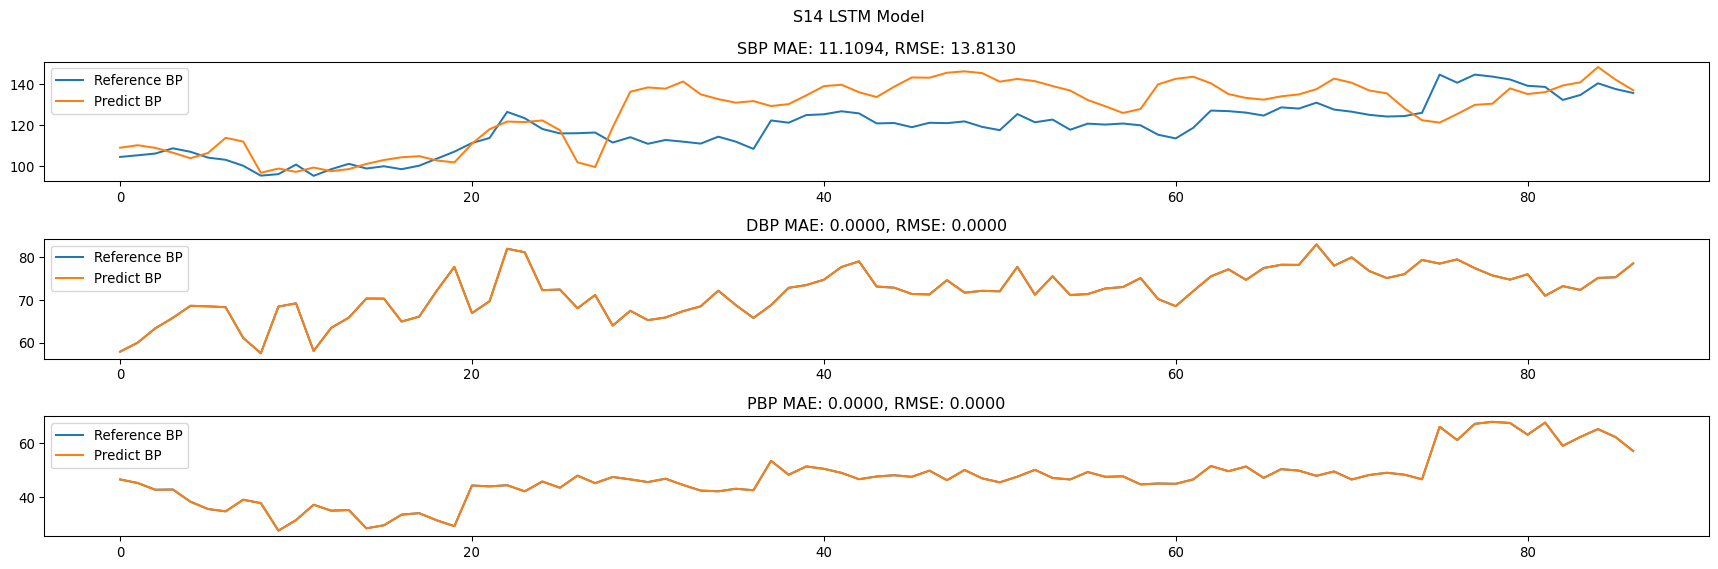

,heart_rate,R_peak,PTT,Max_PPG,Min_PPG,dPPG,PPG_width,High_IPG,Low_IPG,dIPG,IPG_small_area,IPG_large_area,ave_Temp,SBP,DBP,PBP
0,0.8590,0.290777,0.6770,0.420714,0.400552,0.020163,0.759657,0.870048,0.870048,0.000000,0.383023,0.815798,0.303786,0.463282,0.164613,0.298669
1,0.8785,0.321473,0.6785,0.432735,0.404904,0.027831,0.913448,0.871749,0.870950,0.000799,0.142064,0.828088,0.303554,0.488172,0.160424,0.327748
2,0.8590,0.304064,0.6745,0.422435,0.404773,0.017662,0.783977,0.871510,0.870699,0.000811,0.125176,0.811755,0.303324,0.496796,0.160917,0.335880
3,0.8755,0.284256,0.6475,0.416393,0.401896,0.014497,0.737482,0.871699,0.870922,0.000777,0.114271,0.823953,0.303096,0.483982,0.173484,0.310498
4,0.8910,0.329120,0.6755,0.426496,0.396025,0.030472,0.899142,0.871828,0.870979,0.000849,0.113509,0.837327,0.302865,0.495071,0.164120,0.330951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,0.8550,0.310208,0.7110,0.411982,0.393399,0.018582,0.724607,0.914753,0.913701,0.001052,0.297557,0.031986,0.287169,0.480286,0.200591,0.279694
206,0.8630,0.361640,0.7010,0.420751,0.395642,0.025109,0.884835,0.915181,0.913975,0.001205,0.418739,0.026182,0.287971,0.497043,0.185067,0.311976
207,0.7915,0.350312,0.7470,0.412953,0.392529,0.020424,0.719599,0.916064,0.914416,0.001649,0.354443,0.019575,0.288603,0.483243,0.171513,0.311730
208,0.8100,0.295755,0.6940,0.412271,0.403043,0.009228,0.575823,0.916077,0.915062,0.001015,0.166995,0.012816,0.289065,0.467225,0.183588,0.283637


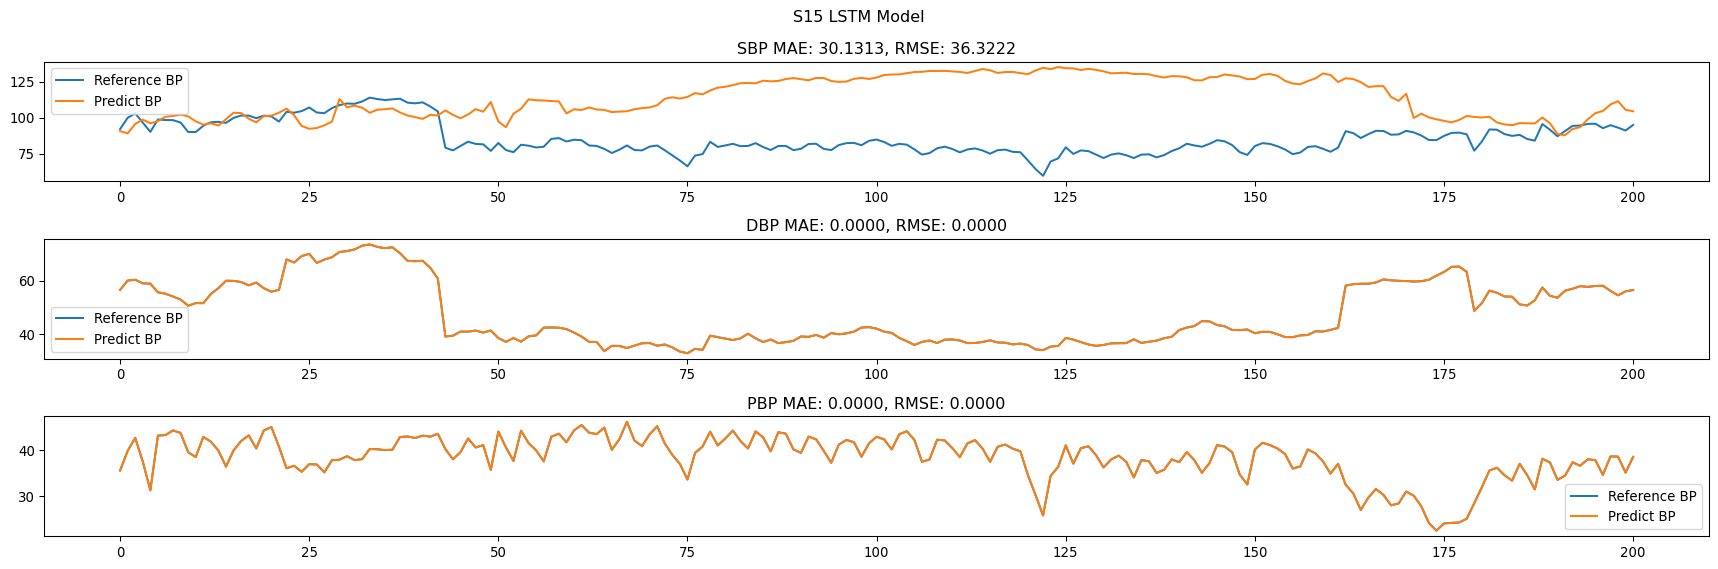

,heart_rate,R_peak,PTT,Max_PPG,Min_PPG,dPPG,PPG_width,High_IPG,Low_IPG,dIPG,IPG_small_area,IPG_large_area,ave_Temp,SBP,DBP,PBP
0,0.7140,0.186762,0.5040,0.493183,0.370457,0.122726,0.615165,0.135842,0.135634,0.000207,0.017414,0.204487,0.959888,0.643420,0.269098,0.374322
1,0.7135,0.162218,0.5265,0.497743,0.377454,0.120288,0.572961,0.135829,0.135629,0.000201,0.012383,0.204900,0.959983,0.645145,0.294234,0.350912
2,0.7080,0.177533,0.5275,0.493576,0.376589,0.116986,0.574392,0.135810,0.135624,0.000186,0.009631,0.203391,0.960145,0.660424,0.292755,0.367669
3,0.7090,0.184906,0.5260,0.479267,0.365347,0.113920,0.594421,0.135785,0.135580,0.000205,0.008697,0.204128,0.960373,0.678906,0.292509,0.386397
4,0.6985,0.188476,0.5170,0.478638,0.363303,0.115335,0.568670,0.135772,0.135573,0.000199,0.013556,0.201425,0.960666,0.709709,0.327255,0.382454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,0.6785,0.198769,0.4860,0.501123,0.375489,0.125635,0.540773,0.147406,0.147112,0.000294,0.027729,0.030866,0.957204,0.891079,0.427551,0.463529
205,0.6715,0.184994,0.4935,0.514882,0.401276,0.113606,0.554363,0.147387,0.147070,0.000317,0.031445,0.030942,0.955361,0.884426,0.433218,0.451207
206,0.6795,0.178164,0.5020,0.513624,0.395458,0.118166,0.542203,0.147344,0.147046,0.000298,0.031770,0.031942,0.953286,0.885658,0.433711,0.451947
207,0.6730,0.154614,0.5265,0.528483,0.398603,0.129880,0.514306,0.147295,0.147009,0.000286,0.028285,0.032194,0.950960,0.892065,0.434697,0.457368


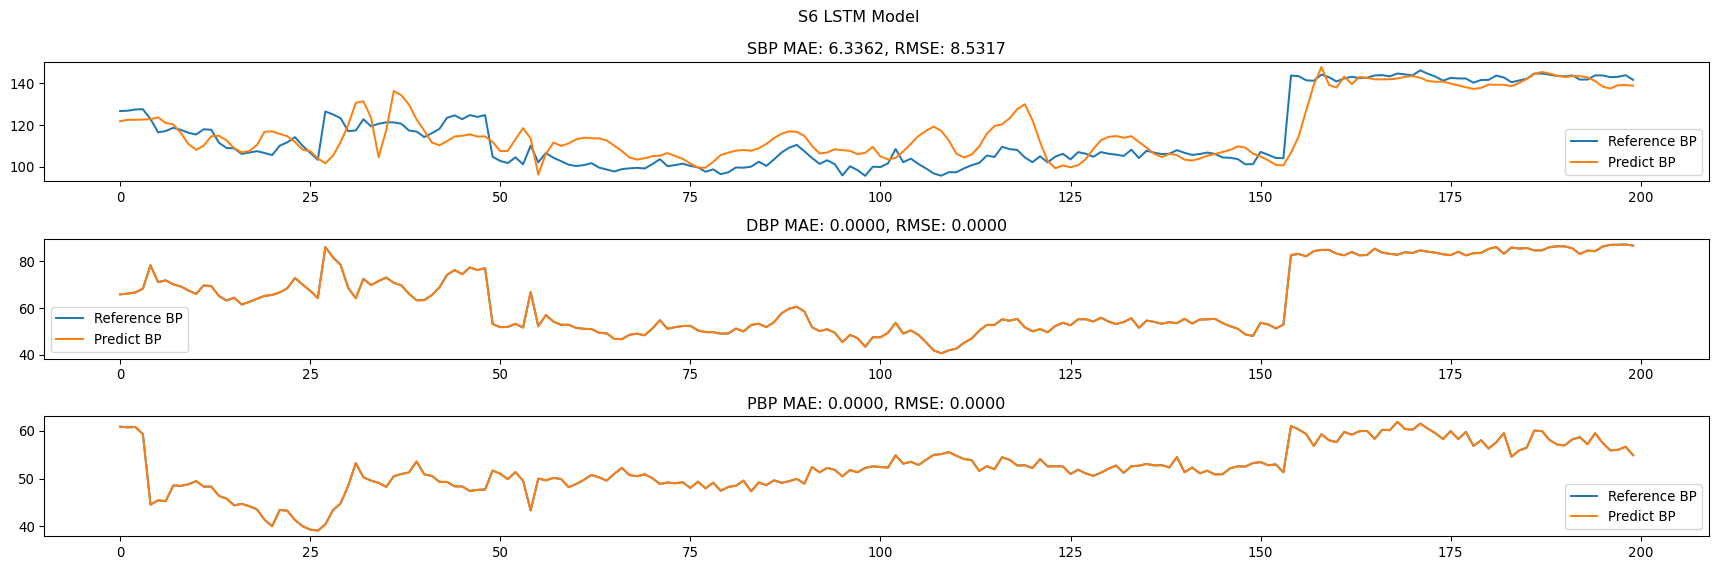

,heart_rate,R_peak,PTT,Max_PPG,Min_PPG,dPPG,PPG_width,High_IPG,Low_IPG,dIPG,IPG_small_area,IPG_large_area,ave_Temp,SBP,DBP,PBP
0,0.7655,0.776606,0.4395,0.351038,0.239476,0.111562,0.644492,0.058477,0.058213,0.000264,0.025370,0.053631,0.513555,0.834648,0.385165,0.449483
1,0.7750,0.798841,0.4455,0.366290,0.224224,0.142066,0.675966,0.058540,0.058227,0.000313,0.044451,0.053921,0.513374,0.896747,0.395761,0.500986
2,0.7610,0.815366,0.4440,0.358664,0.206535,0.152130,0.658798,0.058553,0.058247,0.000306,0.042871,0.052736,0.513203,0.905619,0.405619,0.500000
3,0.7710,0.827149,0.4425,0.338380,0.196393,0.141988,0.651645,0.058536,0.058257,0.000279,0.059529,0.052785,0.513041,0.885904,0.409069,0.476836
4,0.7915,0.828117,0.4565,0.366290,0.196393,0.169898,0.697425,0.058667,0.058288,0.000379,0.070701,0.053942,0.512882,0.897240,0.402661,0.494579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0.7595,0.882222,0.4285,0.358743,0.211566,0.147176,0.673820,0.060813,0.060532,0.000280,0.047722,0.016863,0.488252,0.750616,0.434697,0.315919
106,0.7685,0.826662,0.4275,0.353632,0.205198,0.148434,0.645923,0.060790,0.060414,0.000376,0.046782,0.016977,0.487857,0.753820,0.445786,0.308034
107,0.7825,0.832080,0.4480,0.392942,0.201346,0.191597,0.645207,0.060801,0.060475,0.000326,0.051830,0.017134,0.487286,0.777230,0.439379,0.337851
108,0.7870,0.856040,0.4345,0.386496,0.197650,0.188845,0.652361,0.060832,0.060471,0.000361,0.042548,0.016952,0.486505,0.779448,0.448497,0.330951


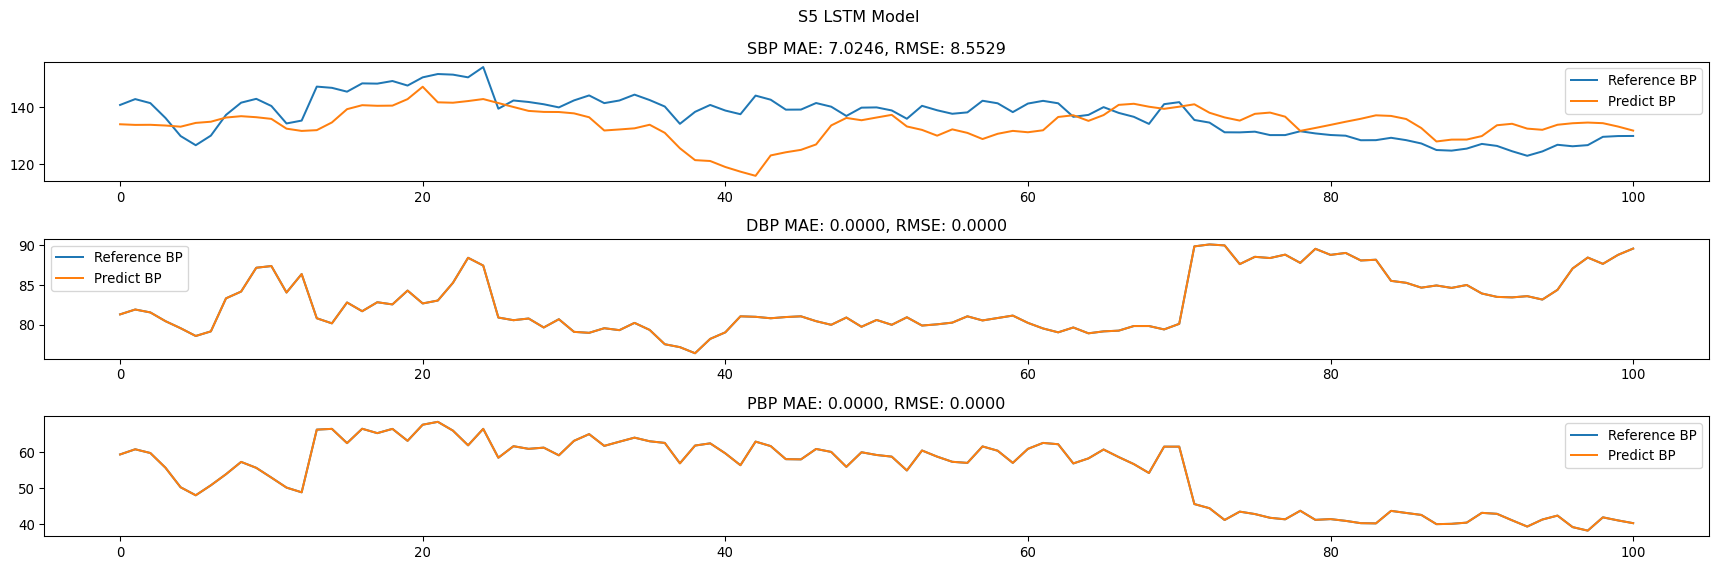

,heart_rate,R_peak,PTT,Max_PPG,Min_PPG,dPPG,PPG_width,High_IPG,Low_IPG,dIPG,IPG_small_area,IPG_large_area,ave_Temp,SBP,DBP,PBP
0,0.8850,0.488936,0.6730,0.415364,0.375268,0.040096,0.984263,0.708626,0.707873,0.000753,0.130275,0.139712,0.250010,0.506900,0.175949,0.330951
1,0.8260,0.476501,0.6940,0.450640,0.410878,0.039762,0.960658,0.708653,0.707909,0.000745,0.091187,0.127821,0.249632,0.504189,0.176442,0.327748
2,0.8675,0.473225,0.6505,0.465933,0.433492,0.032441,0.941345,0.708857,0.708043,0.000813,0.127766,0.132733,0.249298,0.520453,0.205274,0.315180
3,0.8955,0.480520,0.6720,0.467179,0.424959,0.042219,0.999285,0.708869,0.708024,0.000844,0.148157,0.137424,0.248964,0.490143,0.204288,0.285855
4,0.8765,0.471910,0.6805,0.448156,0.417352,0.030804,0.919170,0.708782,0.707981,0.000801,0.122504,0.135260,0.248638,0.434697,0.162395,0.272302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,0.7635,0.470290,0.7630,0.370302,0.353279,0.017023,0.271817,0.712052,0.710886,0.001165,0.164874,0.067448,0.223781,0.510596,0.211188,0.299409
148,0.8195,0.502515,0.6565,0.386370,0.355757,0.030614,0.903433,0.712142,0.710941,0.001201,0.190409,0.071439,0.224782,0.540168,0.224741,0.315426
149,0.7785,0.519587,0.7780,0.434409,0.382027,0.052381,0.922031,0.712203,0.711208,0.000996,0.114971,0.064420,0.226139,0.535732,0.220306,0.315426
150,0.7725,0.396953,0.6570,0.434306,0.428743,0.005563,0.483548,0.712338,0.711407,0.000931,0.118578,0.061895,0.226514,0.460572,0.213159,0.247413


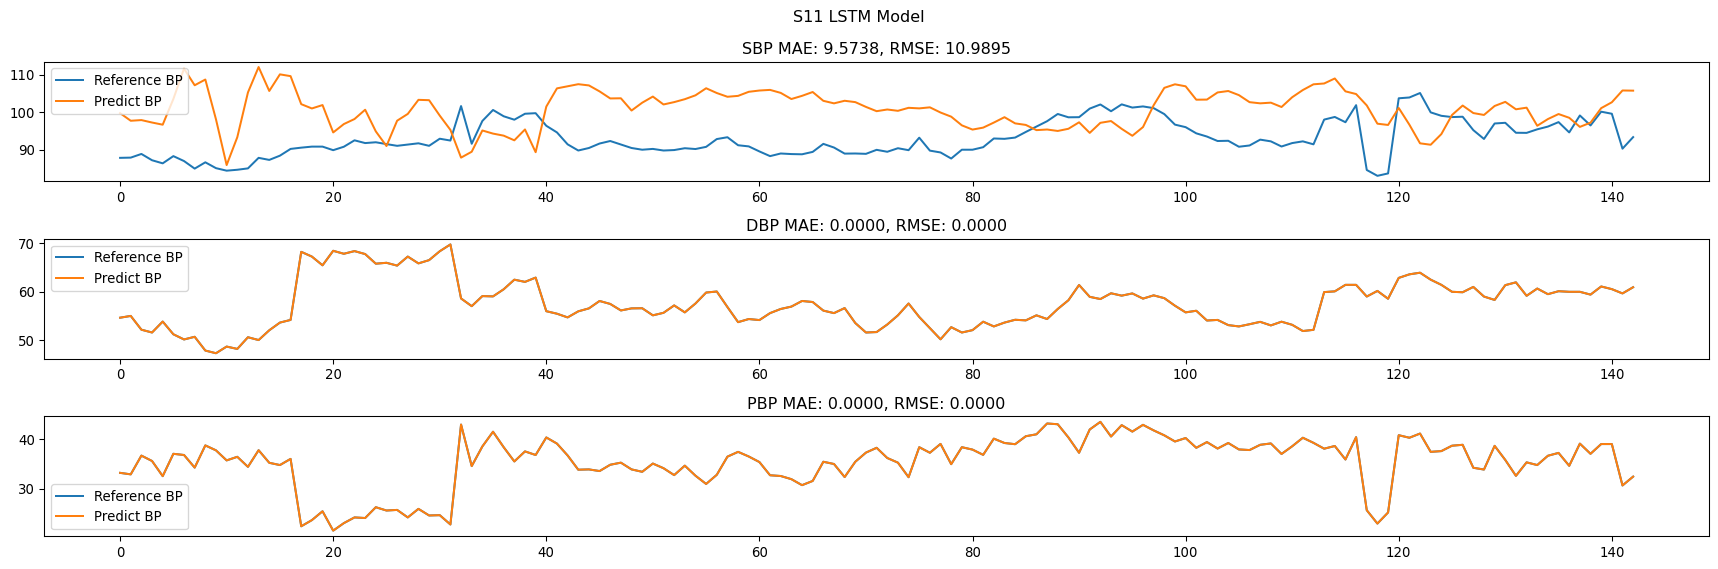

,heart_rate,R_peak,PTT,Max_PPG,Min_PPG,dPPG,PPG_width,High_IPG,Low_IPG,dIPG,IPG_small_area,IPG_large_area,ave_Temp,SBP,DBP,PBP
0,0.8675,0.811640,0.7270,0.441463,0.392263,0.049200,0.926323,0.616791,0.616221,0.000570,0.136673,0.421523,0.879751,0.543618,0.203302,0.340315
1,0.8515,0.809922,0.7090,0.432953,0.409817,0.023136,0.803290,0.616696,0.616059,0.000637,0.128395,0.414371,0.880083,0.535239,0.207984,0.327255
2,0.8150,0.850964,0.7045,0.437486,0.405160,0.032326,0.834764,0.616793,0.616286,0.000507,0.087948,0.394431,0.881107,0.550271,0.244455,0.305816
3,0.8235,0.807901,0.6435,0.444847,0.425957,0.018890,0.817597,0.616805,0.616256,0.000549,0.116519,0.399351,0.881482,0.564071,0.259241,0.304830
4,0.8295,0.804005,0.6835,0.435732,0.416425,0.019307,0.771817,0.616884,0.616423,0.000461,0.072996,0.399306,0.881878,0.552242,0.255052,0.297191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,0.8195,0.852572,0.6205,0.426193,0.414628,0.011565,0.693133,0.625504,0.625007,0.000497,0.143832,0.249120,0.923540,0.661656,0.333662,0.327994
152,0.8385,0.848689,0.6665,0.435418,0.406327,0.029091,0.867668,0.625286,0.624693,0.000593,0.157183,0.259123,0.924346,0.677427,0.334648,0.342780
153,0.8410,0.815413,0.6855,0.424021,0.403234,0.020786,0.779685,0.625094,0.624550,0.000544,0.151871,0.263078,0.925147,0.679152,0.336126,0.343026
154,0.7895,0.849178,0.7300,0.418796,0.398092,0.020704,0.726753,0.624859,0.624300,0.000559,0.137345,0.250574,0.925897,0.662149,0.329473,0.332676


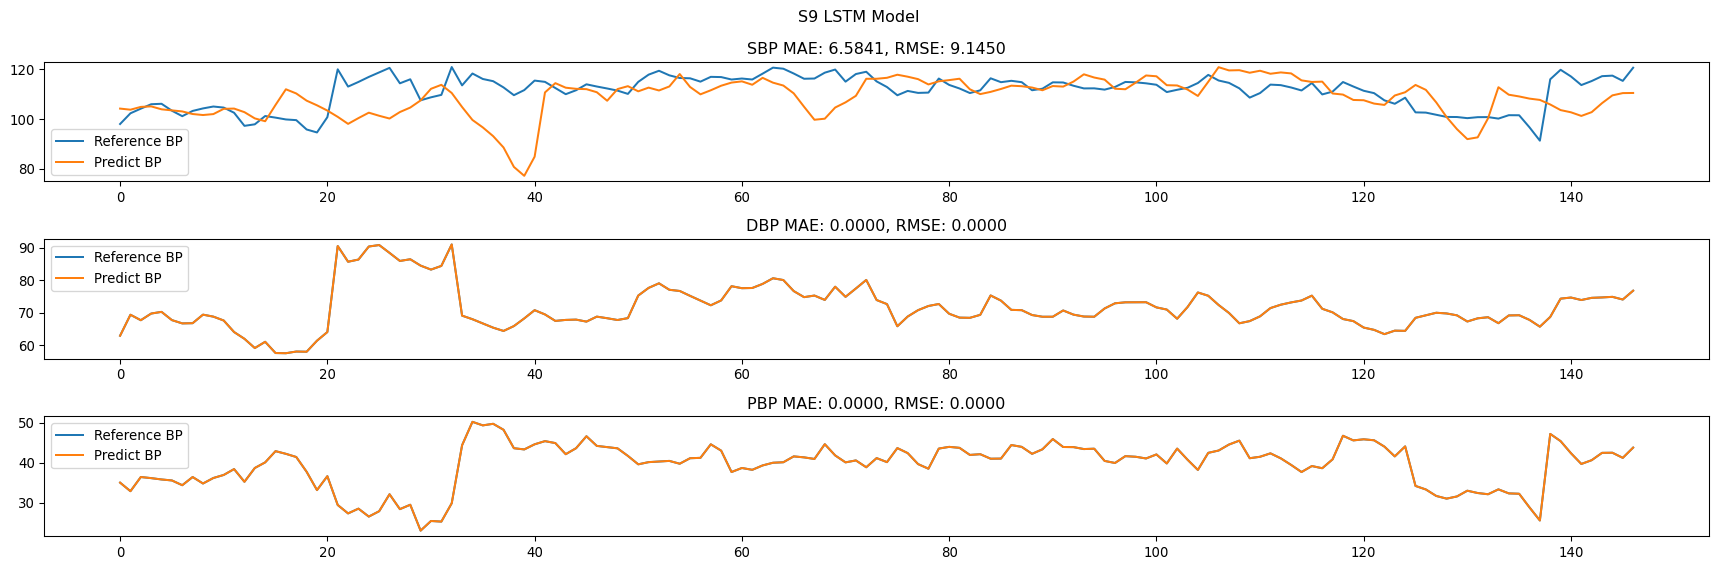

,heart_rate,R_peak,PTT,Max_PPG,Min_PPG,dPPG,PPG_width,High_IPG,Low_IPG,dIPG,IPG_small_area,IPG_large_area,ave_Temp,SBP,DBP,PBP
0,0.8375,0.038299,0.4395,0.520282,0.439602,0.080680,0.630901,0.148988,0.148625,0.000363,0.090488,0.118672,0.168069,0.595860,0.233613,0.362247
1,0.7810,0.034689,0.4360,0.518377,0.441235,0.077142,0.789700,0.148989,0.148601,0.000388,0.053893,0.109704,0.168705,0.582060,0.226959,0.355101
2,0.7610,0.051499,0.4475,0.507369,0.444157,0.063212,0.703147,0.148972,0.148583,0.000389,0.059558,0.107635,0.169321,0.541153,0.248398,0.292755
3,0.7980,0.023588,0.4375,0.518584,0.444252,0.074332,0.663805,0.148936,0.148734,0.000201,0.032516,0.112478,0.169930,0.628388,0.233366,0.395022
4,0.7980,0.020986,0.4275,0.523093,0.445309,0.077784,0.716738,0.148972,0.148603,0.000369,0.066035,0.113073,0.170514,0.609906,0.235830,0.374076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,0.6905,0.038625,0.4205,0.513717,0.444601,0.069115,0.528612,0.152888,0.152691,0.000197,0.020676,0.039719,0.128120,0.542878,0.201824,0.341055
167,0.7050,0.035285,0.4175,0.522746,0.443583,0.079163,0.563662,0.152898,0.152677,0.000221,0.042914,0.040692,0.128606,0.572203,0.193938,0.378265
168,0.7345,0.028407,0.4120,0.524497,0.439775,0.084721,0.619456,0.152879,0.152564,0.000315,0.066395,0.044067,0.129245,0.587974,0.197388,0.390586
169,0.7480,0.036257,0.4140,0.523275,0.439010,0.084265,0.585122,0.152634,0.152421,0.000213,0.020262,0.047046,0.130072,0.577132,0.189995,0.387137


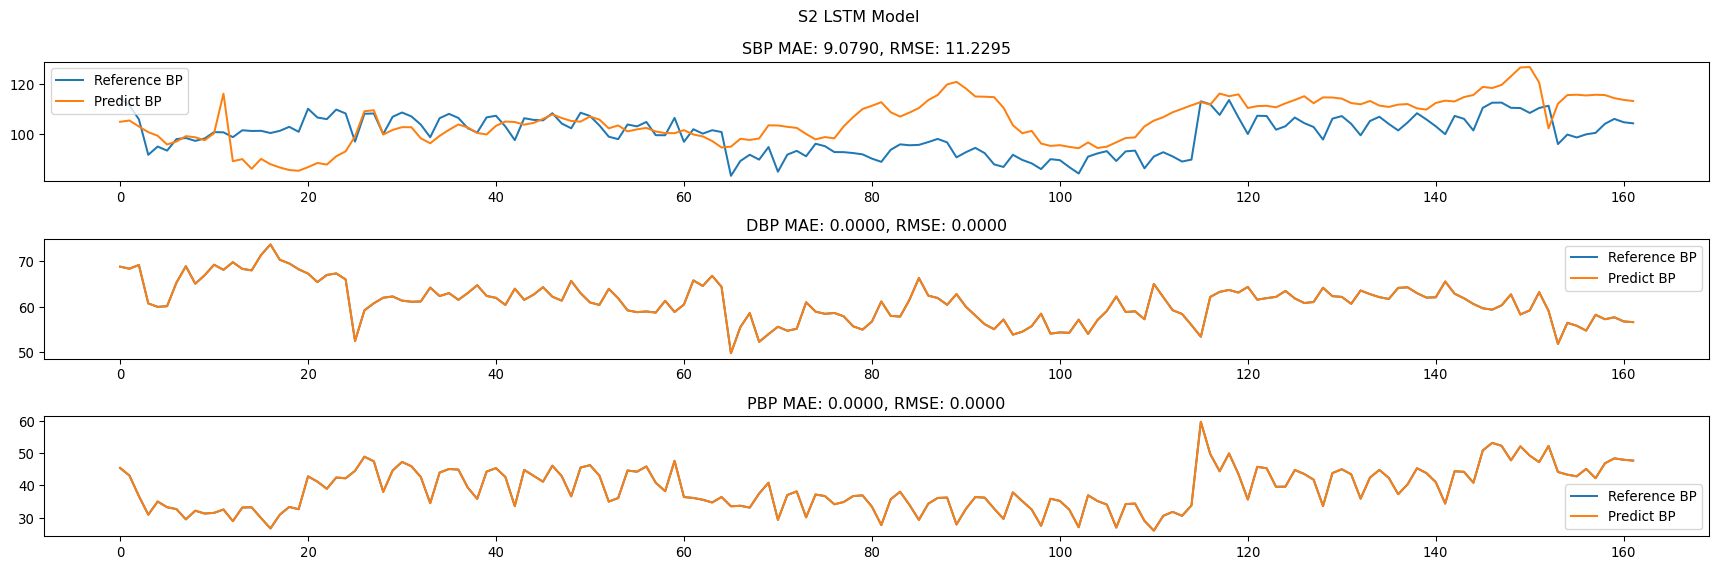

,heart_rate,R_peak,PTT,Max_PPG,Min_PPG,dPPG,PPG_width,High_IPG,Low_IPG,dIPG,IPG_small_area,IPG_large_area,ave_Temp,SBP,DBP,PBP
0,0.8215,0.370983,0.4425,0.571567,0.062110,0.509457,0.813305,0.003585,0.003410,0.000175,0.039267,0.011335,0.918334,0.898226,0.410547,0.487679
1,0.8210,0.328963,0.4430,0.571488,0.107631,0.463858,0.724607,0.003609,0.003410,0.000199,0.038973,0.010911,0.918450,0.880237,0.410301,0.469936
2,0.8615,0.347202,0.4455,0.598219,0.101420,0.496799,0.759657,0.003591,0.003424,0.000166,0.032706,0.011558,0.918727,0.879497,0.401676,0.477822
3,0.8630,0.366296,0.4405,0.636035,0.082394,0.553641,0.775393,0.003635,0.003439,0.000196,0.044033,0.011188,0.919056,0.881715,0.392804,0.488911
4,0.8575,0.377255,0.4410,0.603251,0.063446,0.539804,0.798283,0.003612,0.003426,0.000186,0.034316,0.011179,0.919336,0.881962,0.394283,0.487679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,0.8465,0.394389,0.4485,0.408037,0.200166,0.207871,0.845494,0.000252,0.000067,0.000185,0.030270,0.070437,0.873023,0.728684,0.208231,0.520453
103,0.8830,0.375103,0.4440,0.429579,0.186251,0.243329,0.815451,0.000222,0.000045,0.000178,0.029033,0.073999,0.871567,0.729670,0.210941,0.518728
104,0.9035,0.410902,0.4590,0.456231,0.144503,0.311728,0.819742,0.000225,0.000043,0.000182,0.034665,0.075884,0.870337,0.751602,0.204288,0.547314
105,0.8815,0.436058,0.4475,0.482805,0.127993,0.354812,0.832618,0.000213,0.000022,0.000191,0.041163,0.074480,0.869480,0.730163,0.200099,0.530064


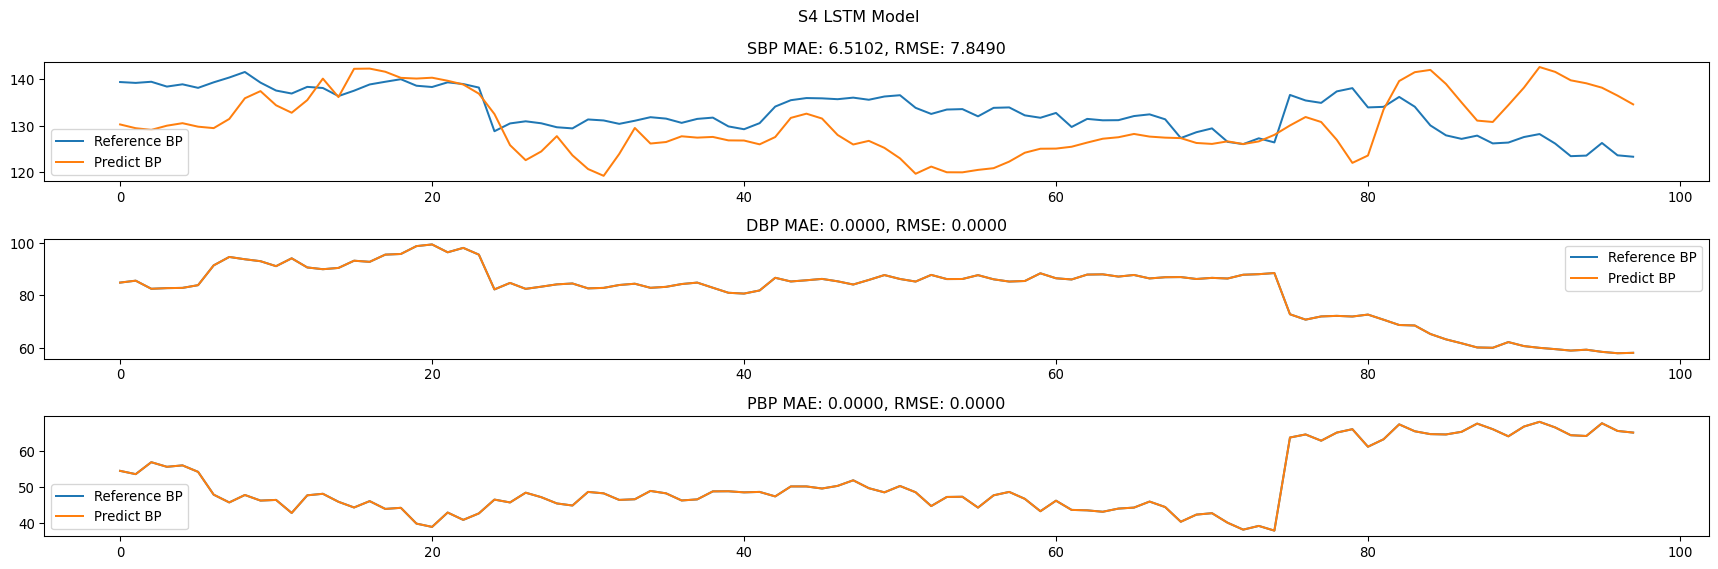

,heart_rate,R_peak,PTT,Max_PPG,Min_PPG,dPPG,PPG_width,High_IPG,Low_IPG,dIPG,IPG_small_area,IPG_large_area,ave_Temp,SBP,DBP,PBP
0,0.8885,0.695603,0.6425,0.411903,0.377651,0.034252,0.951359,0.441942,0.440240,0.001702,0.325896,0.127011,0.507826,0.534007,0.195170,0.338837
1,0.8615,0.612921,0.6660,0.404034,0.384023,0.020011,0.728898,0.442125,0.440625,0.001500,0.265076,0.117725,0.507511,0.588221,0.254066,0.334155
2,0.8795,0.635254,0.5890,0.408815,0.393328,0.015487,0.824034,0.442118,0.440359,0.001759,0.340260,0.121203,0.507201,0.623460,0.278709,0.344751
3,0.9060,0.727043,0.6240,0.410198,0.386110,0.024088,0.866237,0.442292,0.440622,0.001671,0.286366,0.121236,0.506886,0.605224,0.274027,0.331198
4,0.8725,0.737174,0.6720,0.414716,0.386245,0.028471,0.795422,0.442395,0.440644,0.001750,0.312024,0.113981,0.506575,0.603746,0.265648,0.338098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,0.8850,0.667611,0.6575,0.402211,0.368832,0.033379,0.852647,0.443738,0.442190,0.001548,0.244023,0.090319,0.523283,0.549039,0.247413,0.301626
125,0.9000,0.724343,0.7025,0.417969,0.373929,0.044039,0.912017,0.443676,0.442050,0.001626,0.268281,0.093771,0.523294,0.576639,0.250370,0.326269
126,0.8640,0.632026,0.7270,0.422167,0.389003,0.033164,0.773247,0.443728,0.442130,0.001597,0.273001,0.089576,0.523267,0.544357,0.235338,0.309019
127,0.8645,0.618137,0.6605,0.432511,0.409425,0.023086,0.808298,0.443474,0.442025,0.001449,0.188373,0.091161,0.523202,0.545096,0.233613,0.311483


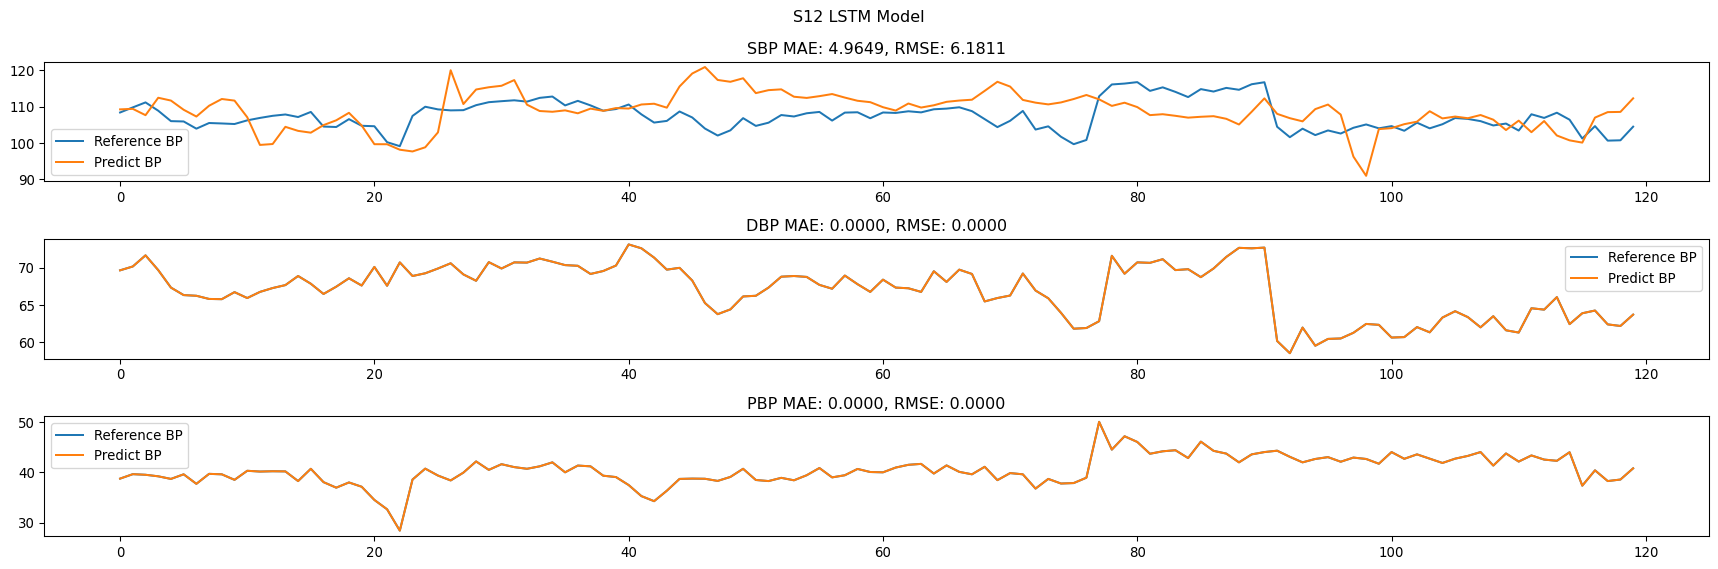

,heart_rate,R_peak,PTT,Max_PPG,Min_PPG,dPPG,PPG_width,High_IPG,Low_IPG,dIPG,IPG_small_area,IPG_large_area,ave_Temp,SBP,DBP,PBP
0,0.8035,0.719995,0.5745,0.478559,0.341446,0.137113,0.721030,0.971299,0.970392,0.000907,0.178255,0.516102,0.591640,0.682109,0.404140,0.277969
1,0.8115,0.709999,0.5600,0.476987,0.332877,0.144110,0.738197,0.971169,0.970210,0.000959,0.190749,0.523856,0.591956,0.689749,0.408576,0.281173
2,0.8000,0.689933,0.5615,0.467946,0.330518,0.137428,0.721030,0.971091,0.970048,0.001043,0.218685,0.518817,0.592313,0.738295,0.481518,0.256777
3,0.7595,0.747166,0.5910,0.461263,0.329417,0.131846,0.657368,0.970997,0.969925,0.001072,0.209589,0.494051,0.592698,0.703056,0.433465,0.269591
4,0.7700,0.734788,0.5800,0.476358,0.343333,0.133025,0.641631,0.970754,0.969800,0.000953,0.171220,0.503333,0.593114,0.741498,0.378019,0.363480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,0.7640,0.739293,0.5295,0.422503,0.311335,0.111169,0.685980,0.972973,0.971620,0.001353,0.296309,0.468446,0.495316,0.879497,0.449975,0.429522
218,0.7855,0.722594,0.5230,0.430837,0.322813,0.108024,0.708155,0.973007,0.971522,0.001485,0.189110,0.476593,0.496291,0.895515,0.454657,0.440858
219,0.7625,0.659079,0.5270,0.438463,0.313772,0.124691,0.658083,0.973052,0.971555,0.001497,0.219467,0.461847,0.497411,0.905619,0.458354,0.447265
220,0.7655,0.663100,0.5190,0.428479,0.322892,0.105587,0.664521,0.973338,0.971900,0.001438,0.195043,0.459855,0.498668,0.883440,0.462543,0.420897


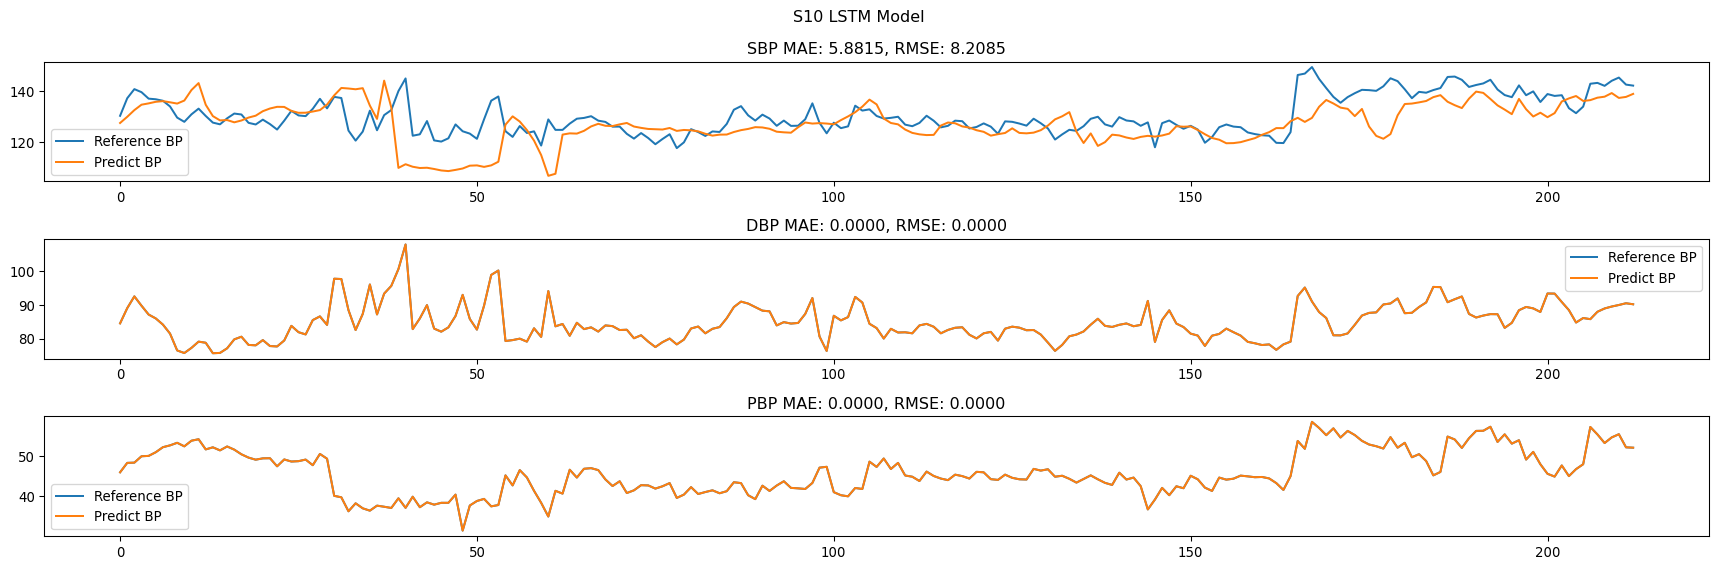

,heart_rate,R_peak,PTT,Max_PPG,Min_PPG,dPPG,PPG_width,High_IPG,Low_IPG,dIPG,IPG_small_area,IPG_large_area,ave_Temp,SBP,DBP,PBP
0,0.8685,0.409487,0.6975,0.423635,0.403318,0.020318,0.829041,0.708628,0.707523,0.001106,0.168225,0.508154,0.322032,0.886397,0.336865,0.549532
1,0.8335,0.362752,0.7515,0.419587,0.401798,0.017789,0.552933,0.708462,0.707342,0.001120,0.240701,0.489335,0.321818,0.864219,0.373829,0.490389
2,0.8775,0.364523,0.6650,0.445497,0.417179,0.028318,0.943491,0.708706,0.707483,0.001224,0.269195,0.515566,0.321608,0.887137,0.348201,0.538935
3,0.8855,0.411766,0.6910,0.452762,0.421572,0.031190,0.879828,0.708327,0.707200,0.001127,0.187968,0.521260,0.321397,0.880237,0.340315,0.539921
4,0.8780,0.407963,0.6810,0.449362,0.425775,0.023586,0.864092,0.708505,0.707306,0.001198,0.237825,0.518435,0.321193,0.833415,0.341548,0.491868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.7775,0.348391,0.7060,0.390892,0.375936,0.014956,0.690987,0.735771,0.734713,0.001059,0.160207,0.011342,0.156108,0.850665,0.448004,0.402661
164,0.8155,0.345179,0.5785,0.390870,0.386197,0.004673,0.593705,0.735987,0.734972,0.001015,0.135317,0.009046,0.155908,0.840808,0.455643,0.385165
165,0.8430,0.393305,0.6760,0.409038,0.381179,0.027859,0.891989,0.735963,0.734895,0.001068,0.152116,0.009351,0.155689,0.870133,0.442090,0.428043
166,0.8765,0.410054,0.6425,0.409887,0.394397,0.015490,0.857654,0.736042,0.735073,0.000969,0.107373,0.007442,0.155453,0.866190,0.438147,0.428043


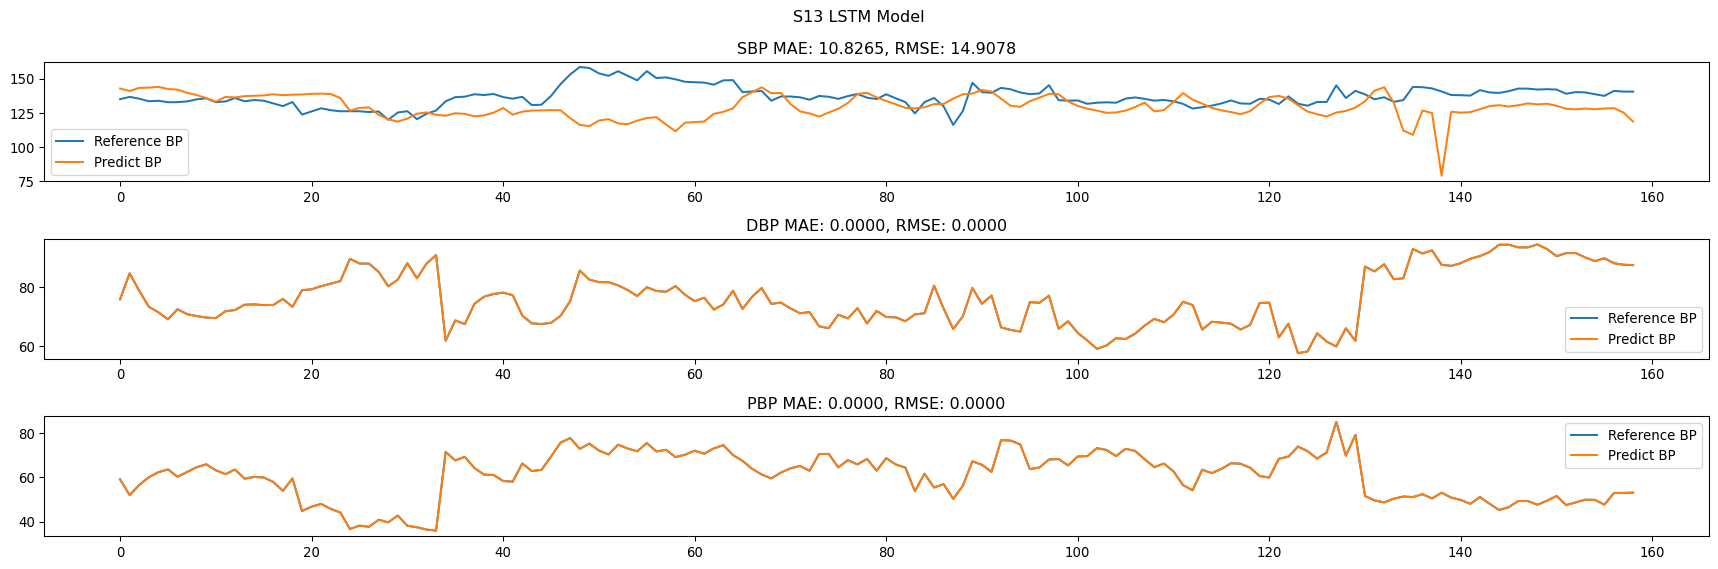

,heart_rate,R_peak,PTT,Max_PPG,Min_PPG,dPPG,PPG_width,High_IPG,Low_IPG,dIPG,IPG_small_area,IPG_large_area,ave_Temp,SBP,DBP,PBP
0,0.8220,0.084567,0.4175,0.763196,0.247711,0.515485,0.764664,0.232407,0.232143,0.000265,0.049139,0.171425,0.571141,0.667324,0.243963,0.423361
1,0.7845,0.103467,0.4110,0.709583,0.272755,0.436828,0.674535,0.232391,0.232038,0.000353,0.044252,0.163713,0.570908,0.645638,0.287087,0.358551
2,0.8380,0.083523,0.4120,0.765037,0.276148,0.488888,0.756080,0.232390,0.232058,0.000332,0.048406,0.175036,0.570678,0.664120,0.268852,0.395269
3,0.8380,0.100580,0.4115,0.792076,0.247831,0.544245,0.773247,0.232374,0.232051,0.000324,0.054544,0.175527,0.570446,0.680877,0.248645,0.432233
4,0.8190,0.098781,0.4115,0.759961,0.238525,0.521436,0.751073,0.232400,0.232074,0.000326,0.050319,0.170973,0.570224,0.683588,0.253820,0.429768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,0.7910,0.103935,0.4275,0.993938,0.092961,0.900976,0.680258,0.238441,0.238170,0.000270,0.059647,0.065414,0.646526,0.638985,0.289059,0.349926
163,0.7780,0.098607,0.4325,0.977676,0.105619,0.872057,0.720315,0.238459,0.238167,0.000292,0.066448,0.064293,0.648197,0.655742,0.307541,0.348201
164,0.7355,0.103861,0.4340,0.888771,0.144685,0.744086,0.688841,0.238440,0.238179,0.000261,0.045929,0.060392,0.649923,0.630360,0.328733,0.301626
165,0.7925,0.105900,0.4305,0.920386,0.188847,0.731539,0.601574,0.238448,0.238164,0.000284,0.060016,0.064876,0.651794,0.682356,0.322326,0.360030


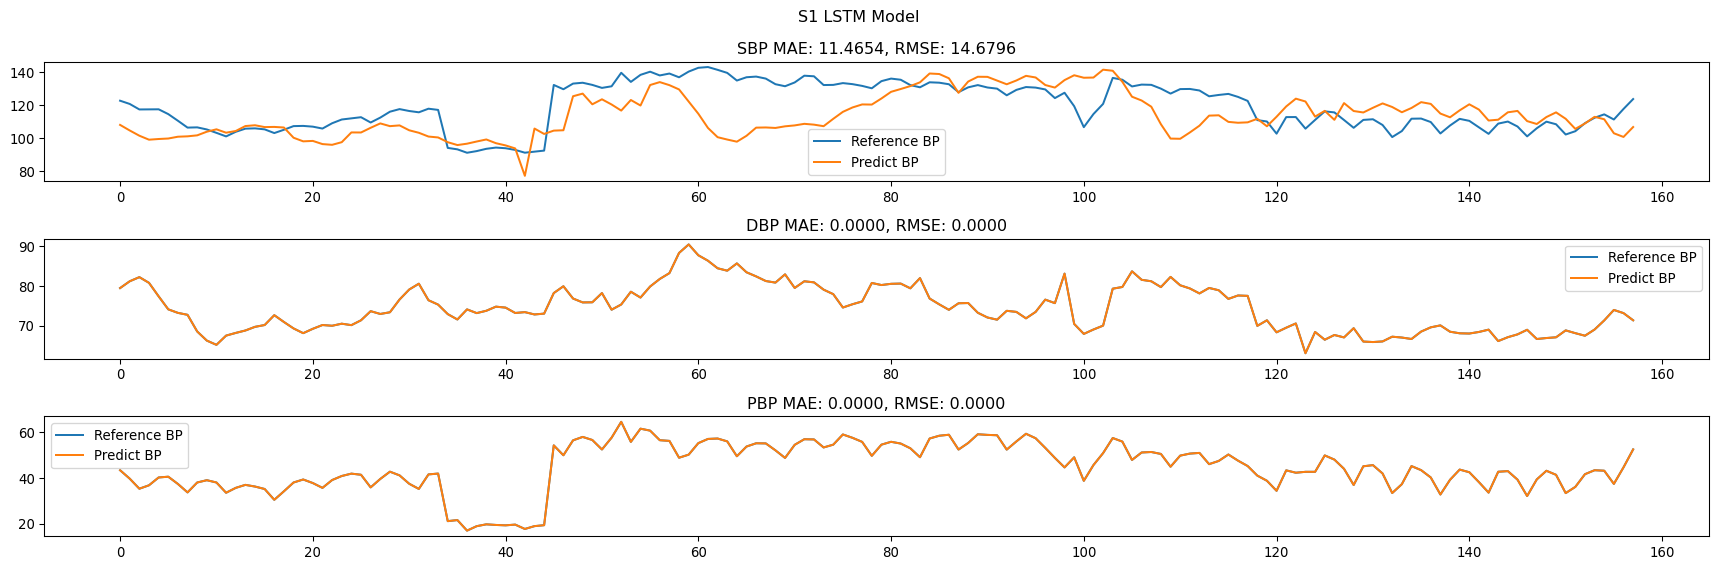

,heart_rate,R_peak,PTT,Max_PPG,Min_PPG,dPPG,PPG_width,High_IPG,Low_IPG,dIPG,IPG_small_area,IPG_large_area,ave_Temp,SBP,DBP,PBP
0,0.8130,0.043602,0.5125,0.471720,0.384373,0.087347,0.743205,0.109530,0.109238,0.000293,0.039531,0.101323,0.053677,0.622967,0.288319,0.334648
1,0.7585,0.061965,0.5220,0.462442,0.390584,0.071859,0.733190,0.109487,0.109266,0.000221,0.026039,0.094334,0.053460,0.577132,0.265895,0.311237
2,0.8705,0.035920,0.5870,0.457804,0.378398,0.079406,0.650930,0.109535,0.109260,0.000275,0.035537,0.108266,0.053233,0.568260,0.259487,0.308773
3,0.7195,0.022375,0.4755,0.462757,0.384687,0.078070,0.656652,0.109566,0.109282,0.000284,0.032794,0.088883,0.053012,0.609906,0.300887,0.309019
4,0.7565,0.050542,0.5320,0.492632,0.400254,0.092378,0.672389,0.109545,0.109303,0.000241,0.023462,0.093473,0.052810,0.583046,0.303105,0.279941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,0.8090,0.032858,0.5305,0.443338,0.365425,0.077912,0.732475,0.114070,0.113818,0.000251,0.027432,0.023471,0.003873,0.485707,0.156727,0.328980
83,0.7690,0.024480,0.5125,0.470383,0.391291,0.079092,0.651645,0.114059,0.113771,0.000288,0.030964,0.022595,0.004379,0.471907,0.150074,0.321833
84,0.7215,0.047341,0.5270,0.479503,0.391213,0.088290,0.630186,0.114076,0.113765,0.000311,0.039684,0.021239,0.004899,0.471907,0.179399,0.292509
85,0.7475,0.020815,0.5645,0.499630,0.417000,0.082630,0.608727,0.113999,0.113680,0.000319,0.045703,0.023430,0.005948,0.536225,0.273287,0.262937


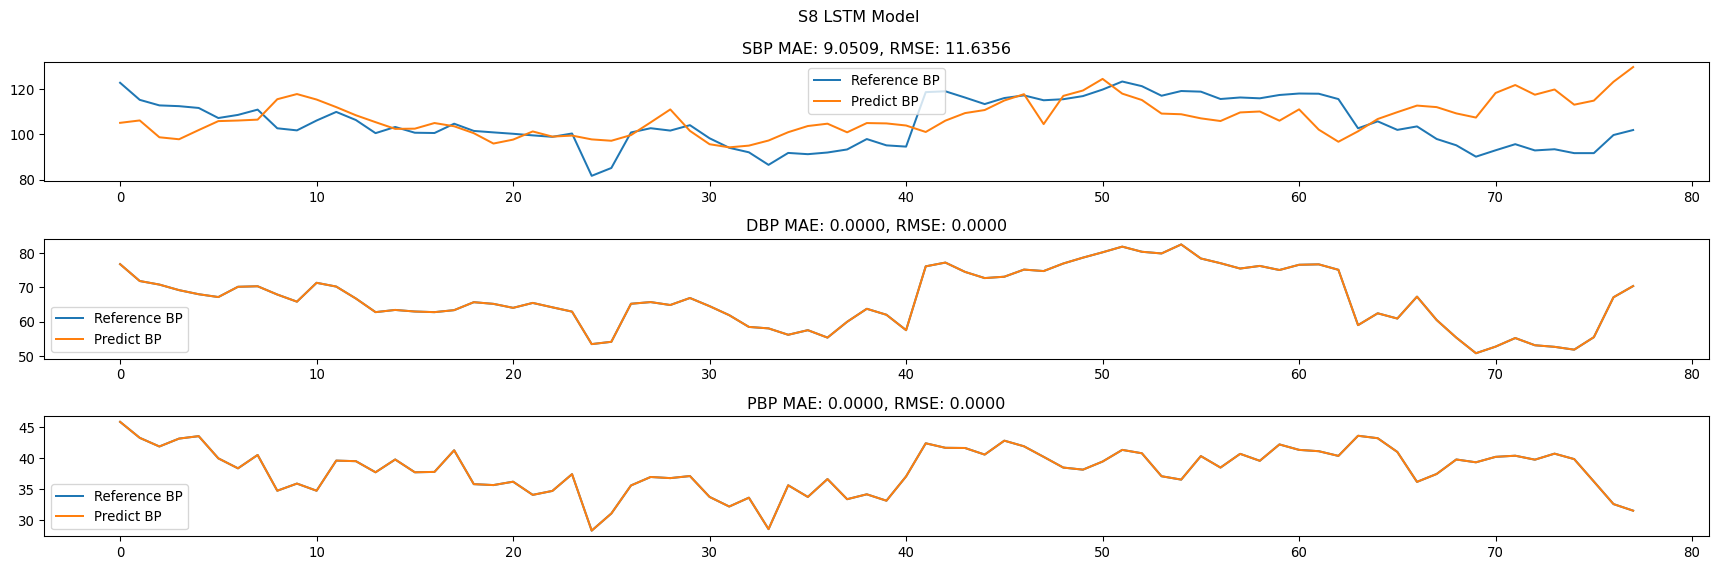

In [46]:
test_root = '/home/jinyanwei/Documents/JYW_COCHE/Project/MMBP/result/Features/Test_Features'
test_ft_all = list(os.walk(test_root))[0][2]

def sbp_test_lstm(ts):
    Test_Ft = pd.read_csv(f"{test_root}/{test_ft_all[ts]}")
    Test_Ftnorm = normlize_features(Test_Ft)
    X_test, y_test = reshape_data(Test_Ftnorm)
    X_test = X_test.to(device)

    y_pred = {}
    y_pred['SBP'] = sbp_lstm_model(X_test)
    y_pred['DBP'] = y_test['DBP']
    y_pred['PBP'] = y_test['PBP']
    
    results = {}
    results['BP'] = ['SBP', 'DBP', 'PBP']
    results['ref_BP'] = [y_test['SBP'][:, -1] * (max_bp - min_bp) + min_bp, y_test['DBP'][:, -1] * (max_bp - min_bp) + min_bp, y_test['PBP'][:, -1] * (max_bp - min_bp)]
    results['pred_BP'] = [(y_pred['SBP'][:, -1] * (max_bp - min_bp) + min_bp).cpu(), (y_pred['DBP'][:, -1] * (max_bp - min_bp) + min_bp).cpu(), (y_pred['PBP'][:, -1] * (max_bp - min_bp)).cpu()]
    results['MAE'] = ["{:.4f}".format(torch.mean(torch.abs(results['ref_BP'][i] - results['pred_BP'][i])).item()) for i in range(3)]
    results['RMSE'] = ["{:.4f}".format(torch.sqrt(torch.mean((results['ref_BP'][i] - results['pred_BP'][i]) ** 2)).item()) for i in range(3)]

    ## Compare BPs
    #if float(results["MAE"][0]) <= 7 or float(results["MAE"][1])<=3:
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(18, 6), dpi=96)
    for i in range(3):
        axs[i].plot(results['ref_BP'][i], label='Reference BP')
        axs[i].plot(results['pred_BP'][i].cpu().detach().numpy(), label='Predict BP')
        axs[i].set_title(f'{results["BP"][i]} MAE: {results["MAE"][i]}, RMSE: {results["RMSE"][i]}')
        axs[i].legend()
    fig.suptitle(f"{test_ft_all[ts].split('_')[0]} LSTM Model")
    plt.tight_layout()
    #plt.savefig(f'{result_path}/S1_LSTM_{layers}layers_{num_epochs}epochs.png', format='png')
    plt.show()
    return 

for t in range(len(test_ft_all)):
    sbp_test_lstm(t)